In [1]:
import tensorflow as tf
import numpy as np

In [2]:
inputs_shape = (160, 160)
channel = (3,)

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = datagen.flow_from_directory(
    'dataset_three_classes/train',
    target_size=inputs_shape,
    batch_size=64,
    class_mode='categorical'
)

test_datagen = datagen.flow_from_directory(
    'dataset_three_classes/test',
    target_size=inputs_shape,
    batch_size=64,
    class_mode='categorical'
)

Found 14281 images belonging to 3 classes.
Found 6620 images belonging to 3 classes.


In [4]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

def swish(inputs):
    x = tf.nn.sigmoid(inputs)
    x = tf.multiply(x, inputs)
    return x

def relu(inputs):
    return tf.nn.relu(inputs)
    

Training Combination :

1. Activation function :
-relu
-mish
-swish

2. optimizer
-SGD
-RMSProp
-Adam

In [89]:
def create_model(activation=relu, input_shape=(160, 160, 3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=activation),
        #tf.keras.layers.Dense(256, activation=activation),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.summary()

    return model

In [90]:
max_epoch = 20
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < max_epoch:
        return 0.0001

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [91]:
model = create_model(activation=mish, input_shape=inputs_shape + channel)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler(0)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 160, 160, 64)      1792      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 80, 80, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 80, 80, 64)        36928     
                                                                 
 conv2d_69 (Conv2D)          (None, 80, 80, 64)        36928     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 40, 40, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 40, 40, 128)     

In [92]:
with tf.device('/gpu:0'):
    history = model.fit(train_datagen, epochs=max_epoch, validation_data=test_datagen, verbose=1, callbacks=[scheduler_callback])

Epoch 1/20
224/224 [==============================] - 49s 217ms/step - loss: 0.8990 - accuracy: 0.5830 - val_loss: 0.9679 - val_accuracy: 0.5621 - lr: 0.0010
Epoch 2/20
224/224 [==============================] - 48s 214ms/step - loss: 0.7278 - accuracy: 0.6745 - val_loss: 0.8967 - val_accuracy: 0.6601 - lr: 0.0010
Epoch 3/20
224/224 [==============================] - 48s 214ms/step - loss: 0.6991 - accuracy: 0.6870 - val_loss: 0.8961 - val_accuracy: 0.6242 - lr: 0.0010
Epoch 4/20
224/224 [==============================] - 48s 215ms/step - loss: 0.6131 - accuracy: 0.7258 - val_loss: 1.0263 - val_accuracy: 0.6399 - lr: 0.0010
Epoch 5/20
224/224 [==============================] - 48s 214ms/step - loss: 0.5191 - accuracy: 0.7756 - val_loss: 1.1224 - val_accuracy: 0.6761 - lr: 0.0010
Epoch 6/20
224/224 [==============================] - 48s 215ms/step - loss: 0.4091 - accuracy: 0.8307 - val_loss: 1.0520 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 7/20
224/224 [==============================] 

In [40]:
# Model Validation
eval_hist_train = model.evaluate(train_datagen)
eval_hist_test = model.evaluate(test_datagen)

104/104 [==============================] - 8s 78ms/step - loss: 1.9078 - accuracy: 0.7101


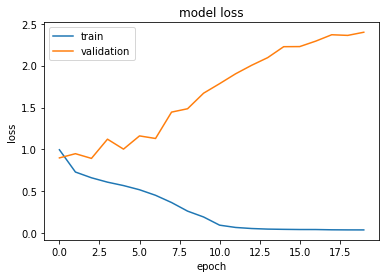

In [48]:
import matplotlib.pyplot as plt

# Save Train result
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig2.savefig('history/loss_shallow_mish_adam.jpg')

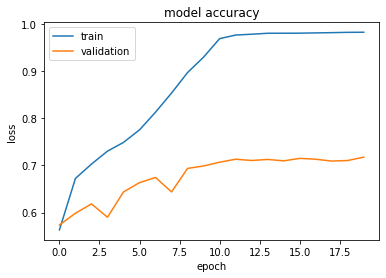

In [49]:

import matplotlib.pyplot as plt

# Save Train result
fig2 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig2.savefig('history/acc_shallow_mish_adam.jpg')

In [50]:
# Save model
model.save("weight/adam_mish.h5")